<h1>Cancer Classifier</h1> 


<h2>Preparation</h2>


In [17]:
# Import the libraries we need to use in this lab

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
import os
import random
import time
from PIL import Image
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import Subset, DataLoader

<h2>Define dataset class</h2>


In [10]:
# Define your dataset class
class CancerDataset(Dataset):
    # Constructor
    def __init__(self, transform=None, train=True):
        # Directory of the data
        directory = "C:/Users/ASUS/Documents/Coursera/Project for Portfolio/Cancer Classification/Data"
        normal = "Normal"
        glioma = "Glioma Tumor"
        meningioma = "Meningioma Tumor"
        pituitary =  "Pituitary Tumor"
        
        # Path of the negative and positive data
        normal_path = os.path.join(directory, normal)
        glioma_path = os.path.join(directory, glioma)
        meningioma_path = os.path.join(directory, meningioma)
        pituitary_path = os.path.join(directory, pituitary)
        
        # Get the data
        normal_files = [os.path.join(normal_path, file) for file in os.listdir(normal_path)]
        normal_files.sort()
        
        glioma_files = [os.path.join(glioma_path, file) for file in os.listdir(glioma_path)]
        glioma_files.sort()
        
        meningioma_files = [os.path.join(meningioma_path, file) for file in os.listdir(meningioma_path)]
        meningioma_files.sort()
        
        pituitary_files = [os.path.join(pituitary_path, file) for file in os.listdir(pituitary_path)]
        pituitary_files.sort()
        
        # Number of samples
        number_of_samples = len(normal_files) + len(glioma_files) + len(meningioma_files) + len(pituitary_files)
        
        self.all_files = [None] * number_of_samples
        self.all_files[0:len(normal_files)] = normal_files
        self.all_files[len(normal_files):(len(normal_files)+len(glioma_files))] = glioma_files
        self.all_files[(len(normal_files) + len(glioma_files)):(len(normal_files) + len(glioma_files) + len(meningioma_files))] = meningioma_files
        self.all_files[(len(normal_files) + len(glioma_files) + len(meningioma_files)):] = pituitary_files
        
        # Assign class labels (0: Normal, 1: Glioma, 2: Meningioma, 3: Pituitary)
        self.Y = torch.zeros([number_of_samples], dtype=torch.long)
        self.Y[0:len(normal_files)] = 0
        self.Y[len(normal_files):(len(normal_files)+len(glioma_files))] = 1
        self.Y[(len(normal_files) + len(glioma_files)):(len(normal_files) + len(meningioma_files))] = 2
        self.Y[(len(normal_files) + len(glioma_files) + len(meningioma_files)):] = 3
        
        # Shuffle the dataset
        combined = list(zip(self.all_files, self.Y))  # Pair files with labels
        random.shuffle(combined)  # Shuffle the pairs
        self.all_files, self.Y = zip(*combined)  # Unzip the shuffled pairs
        self.all_files = list(self.all_files)  # Convert back to list
        self.Y = torch.tensor(self.Y, dtype=torch.long)  # Convert labels back to tensor

        self.transform = transform
        
        # Define the train and test dataset
        if train==True:
            self.all_files=self.all_files[0:int(number_of_samples*0.8)]
            self.Y=self.Y[0:int(number_of_samples*0.8)]
            self.len=len(self.all_files)

        else:
            self.all_files=self.all_files[int(number_of_samples*0.8):]
            self.Y=self.Y[int(number_of_samples*0.8):]
            self.len=len(self.all_files)

    # Get the length of the dataset
    def __len__(self):
        return self.len

    # Getter to retrieve an image and label pair
    def __getitem__(self, idx):
        image = Image.open(self.all_files[idx]).convert('RGB')  # Ensure all images are RGB
        y = self.Y[idx]

        # If there is a transform, apply it
        if self.transform:
            image = self.transform(image)

        return image, y

<h2>Class CNN model</h2>


In [24]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, out_1=32, out_2=64, out_3=64):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=3, padding=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, stride=1, padding=1)
        self.maxpool3=nn.MaxPool2d(kernel_size=2)
        
        self.fc1_input_size = out_3 * 28 * 28
        
        self.fc1 = nn.Linear(self.fc1_input_size, 4)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = x.view(-1, self.fc1_input_size)
        x = self.fc1(x)
        return x

<h2>Function criterion</h2>


In [13]:
def Criterion():
    criterion = nn.CrossEntropyLoss()

    return Criterion

<h2>Function optimizer</h2>


In [14]:
def Optimizer(model, learning_rate):
    lr = learning_rate
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
    
    return optimizer

<h2>Import dataset</h2>


In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transforms with the computed mean and std
transform_rotate = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
<h2>Import dataset</h2>

# Create training and validation datasets using the normalization
train_dataset = CancerDataset(transform=transform_rotate, train=True)
validation_dataset = CancerDataset(transform=transform, train=False)

<h2>Define ML model, criterion, optimizer, and datasets</h2>


In [25]:
# Define the model
model = CNN()

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = Optimizer(model, 0.001)

# Define the train and validation dataset loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

In [26]:
# Machine learning model
print(model)

CNN(
  (cnn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=4, bias=True)
)


<h2>Run the model</h2>


In [27]:
n_epochs=5
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
Loss=0
start_time = time.time()

for epoch in range(n_epochs):
    for x, y in train_loader:
        # Train the model
        model.train() 
        
        # Clear gradient
        optimizer.zero_grad()
        
        # Make a prediction 
        z = model(x)
        
        # Calculate loss 
        loss = criterion(z, y)
        
        # Calculate gradients of parameters
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Add loss to the array
        loss_list.append(loss.data)
    
    correct=0
    
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        
        #make a prediction 
        z = model(x_test)
        
        #find max 
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()

    accuracy = correct / N_test
    accuracy_list.append(accuracy)

In [28]:
accuracy

0.9079584775086506

Text(0.5, 1.0, 'Loss vs Iteration')

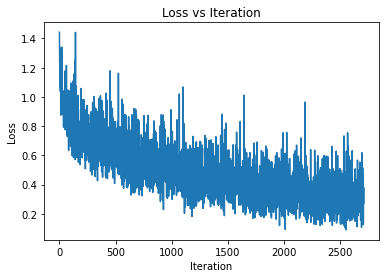

In [29]:
# Plot the loss and accuracy

plt.plot( loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')